In [1]:
# Import packages for file manipulation, data manipulation, and plotting
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plot
# Import module for altering output display
from IPython.display import clear_output
# Import packages for bayesian optimization
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization
# Import XGBoost gradient boosting implementations
from xgboost import XGBClassifier
from xgboost import XGBRegressor
# Import modules for model selection, cross validation, random forest, and performance from Scikit Learn
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.externals import joblib

In [2]:
# Define variable sets
predictor_metrics = ['compoundTopographic', 'dateFreeze_2000s', 'dateThaw_2000s', 'elevation', 'floodplainsDist', 'growingSeason_2000s', 'heatLoad', 'integratedMoisture', 'precipAnnual_2000s', 'roughness', 'siteExposure', 'slope', 'streamLargeDist', 'streamSmallDist', 'summerWarmth_2000s', 'surfaceArea', 'surfaceRelief', 'aspect', 'may_2_blue', 'may_evi2', 'may_nbr', 'may_ndmi', 'may_ndsi', 'may_ndvi', 'may_ndwi', 'june_2_blue', 'june_evi2', 'june_nbr', 'june_ndmi', 'june_ndsi', 'june_ndvi', 'june_ndwi', 'july_2_blue', 'july_evi2', 'july_nbr', 'july_ndmi', 'july_ndsi', 'july_ndvi', 'july_ndwi', 'august_2_blue', 'august_evi2', 'august_nbr', 'august_ndmi', 'august_ndsi', 'august_ndvi', 'august_ndwi', 'september_2_blue', 'september_evi2', 'september_nbr', 'september_ndmi', 'september_ndsi', 'september_ndvi', 'september_ndwi']
zero_variable = ['zero']
strata = ['strata']
cover = ['cover']
retain_variables = ['project', 'siteID', 'siteCode', 'methodSurvey', 'methodCover']
coordinates = ['POINT_X', 'POINT_Y']
all_variables = retain_variables + coordinates + predictor_metrics + zero_variable + strata + cover
absence = ['absence']
presence = ['presence']
response = ['response']
prediction = ['prediction']
output_variables = all_variables + absence + presence + response + prediction

In [3]:
# Define input file
input_file = 'K:/VegetationEcology/Data_Harmonization/Project_GIS/Data_Output/continuous/speciesData/betula_nana.csv'
convergence_regressor = 'K:/VegetationEcology/Data_Harmonization/Project_GIS/convergence.png'
# Create data frame of input data
input_data = pd.read_csv(input_file)
input_data.reset_index()
# Convert values to floats
input_data[predictor_metrics + cover + coordinates] = input_data[predictor_metrics + cover + coordinates].astype(float)
# Convert values to integers
input_data[strata + zero_variable] = input_data[strata + zero_variable].astype(int)
# Shuffle the data
input_data = shuffle(input_data)

In [4]:
# Subset the data to just presences
presence_data = input_data[input_data[cover[0]] >= 1]
presence_data = presence_data[presence_data['methodCover'] == 'Quantitative']
presence_data = presence_data[presence_data['project'] == 'AIM NPR-A']

In [5]:
# Split the X and y data
X = presence_data[predictor_metrics]
y = presence_data[cover[0]]
# Shuffle data
X, y = shuffle(X, y)

In [6]:
# Create an xgboost regressor with default settings
xgbRegressor = XGBRegressor()
# Test the performance of the default xgboost regressor using 5-fold cross validation
baseline_xgbRegressor = cross_val_score(xgbRegressor, X, y, scoring='neg_mean_squared_error', cv=5).mean()
# Display the RMSE of the untuned xgboost regressor
np.sqrt(baseline_xgbRegressor*-1)

7.655335308808768

In [7]:
# Create a random forest regressor with 5000 trees
rfRegressor = RandomForestRegressor(n_estimators=5000,
                                    criterion='mse',
                                    bootstrap=True,
                                    oob_score=False,
                                    n_jobs=1)
# Test the performance of the random forest regressor using 5-fold cross validation
baseline_rfRegressor = cross_val_score(rfRegressor, X, y, scoring='neg_mean_squared_error', cv=5).mean()
# Display the RMSE of the random forest regressor
np.sqrt(baseline_rfRegressor*-1)

8.116287732947866

In [8]:
# Define an optimization objective function for the xgboost regressor
def cvRegressor(parameters):
    parameters = parameters[0]
    score = cross_val_score(
        XGBRegressor(max_depth=int(parameters[0]),
                     learning_rate=parameters[1],
                     n_estimators=int(parameters[2]),
                     silent=True,
                     objective='reg:linear',
                     booster='gbtree',
                     n_jobs=1,
                     gamma=parameters[3],
                     min_child_weight=int(parameters[4]),
                     max_delta_step=int(parameters[5]),
                     subsample=parameters[6],
                     colsample_bytree=parameters[7],
                     colsample_bylevel=parameters[8],
                     reg_alpha=parameters[9],
                     reg_lambda=parameters[10],
                     scale_pos_weight=parameters[11]),
        X, y, scoring='neg_mean_squared_error', cv=5).mean()
    score = np.array(score)
    return score

In [9]:
# Define an optimization function
def bayesianOptimizer(objective_function, X, y, plot_file):
    # Create the hyperparameter search domain
    domain=[{'name': 'max_depth', 'type': 'discrete', 'domain': (3, 10)},
            {'name': 'learning_rate', 'type': 'continuous', 'domain': (0, 1)},
            {'name': 'n_estimators', 'type': 'discrete', 'domain': (500, 5000)},
            {'name': 'gamma', 'type': 'continuous', 'domain': (0, 5)},
            {'name': 'min_child_weight', 'type': 'discrete', 'domain': (0, 10)},
            {'name': 'max_delta_step', 'type': 'continuous', 'domain': (0, 5)},
            {'name': 'subsample', 'type': 'continuous', 'domain': (0.5, 1)},
            {'name': 'colsample_bytree', 'type': 'continuous', 'domain': (0.3, 1.0)},
            {'name': 'colsample_bylevel', 'type': 'continuous', 'domain': (0.3, 1.0)},
            {'name': 'reg_alpha', 'type': 'continuous', 'domain': (1, 10)},
            {'name': 'reg_lamda', 'type': 'continuous', 'domain': (1, 10)},
            {'name': 'scale_pos_weight', 'type': 'continuous', 'domain': (1, 5)}]
    # Initialize the Bayesian Optimizer
    optimizer = BayesianOptimization(f=objective_function,
                                     domain=domain,
                                     model_type='GP',
                                     initial_design_numdata=10,
                                     initial_design_type='random',
                                     acquisition_type ='EI',
                                     exact_feval=False,
                                     maximize=True)
    # Run 250 iterations of optimization
    optimizer.run_optimization(max_iter=50)
    # Plot the convergence of the best solution
    optimizer.plot_convergence(filename=plot_file)
    # Return results
    return optimizer

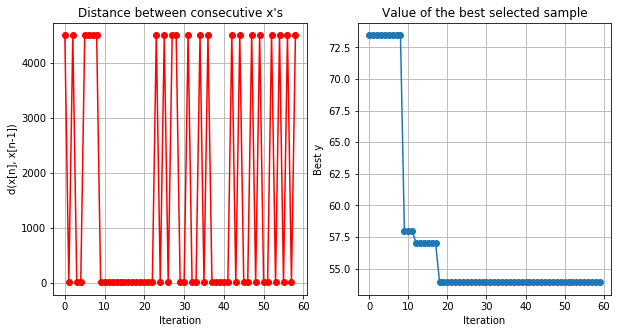

In [10]:
# Conduct bayesian optimization of xgboost regressor
optimizer_regress = bayesianOptimizer(cvRegressor, X, y, convergence_regressor)

In [11]:
# Display lowest RMSE score achieved
np.sqrt(np.amin(optimizer_regress.Y))

7.34187999718485

In [12]:
# Select best set of hyperparameters for the regressor
regressor_parameters = optimizer_regress.X[np.argmin(optimizer_regress.Y)]
# Display best hyperparameters for the regressor
regressor_parameters

array([3.00000000e+00, 7.33989615e-02, 5.00000000e+03, 3.38803848e+00,
       1.00000000e+01, 0.00000000e+00, 1.00000000e+00, 5.54018341e-01,
       6.14461782e-01, 6.01238615e+00, 7.61228149e+00, 1.77811691e+00])